In [6]:
import pandas as pd
import numpy as np
from numpy import array
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, ConvLSTM2D, ConvLSTM1D, Dropout,Conv2D, TimeDistributed, Conv1D, MaxPooling1D, Flatten, RepeatVector, MaxPooling2D, MaxPooling3D, BatchNormalization
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.utils import set_random_seed
from keras.callbacks import EarlyStopping
from datetime import timedelta

In [7]:
df = pd.read_csv('Gold_Price_3.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-05-03,1292.699951,1301.500000,1284.500000,1290.699951,1290.699951,151
1,2016-05-04,1286.900024,1290.000000,1273.000000,1273.300049,1273.300049,109
2,2016-05-05,1282.900024,1286.000000,1270.800049,1271.400024,1271.400024,330
3,2016-05-06,1278.599976,1295.599976,1276.900024,1292.900024,1292.900024,305
4,2016-05-09,1286.500000,1286.500000,1262.300049,1265.599976,1265.599976,341
...,...,...,...,...,...,...,...
1756,2023-04-26,1997.800049,1998.800049,1985.599976,1985.699951,1985.699951,615
1757,2023-04-27,1990.599976,2002.300049,1979.900024,1989.900024,1989.900024,355
1758,2023-04-28,1986.900024,1990.099976,1977.699951,1990.099976,1990.099976,152
1759,2023-05-01,1980.099976,2005.000000,1976.900024,1983.400024,1983.400024,210


In [8]:
df['Date'] = pd.to_datetime(df['Date']) 
df['Date']

0      2016-05-03
1      2016-05-04
2      2016-05-05
3      2016-05-06
4      2016-05-09
          ...    
1756   2023-04-26
1757   2023-04-27
1758   2023-04-28
1759   2023-05-01
1760   2023-05-02
Name: Date, Length: 1761, dtype: datetime64[ns]

In [9]:
data = df[['Close']].values
data

array([[1290.69995117],
       [1273.30004883],
       [1271.40002441],
       ...,
       [1990.09997559],
       [1983.40002441],
       [2014.30004883]])

In [10]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

In [11]:
data_scaled

array([[0.17635586],
       [0.15751868],
       [0.15546171],
       ...,
       [0.93352817],
       [0.92627479],
       [0.95972723]])

In [12]:
def Train_test_split(sequence, n_steps, train_size, test_size):
    data_train = sequence[:train_size]
    data_test = sequence[train_size:train_size+test_size]
    data_valid = sequence[train_size+test_size:]
    
    X_train, X_test, X_valid, y_train, y_test, y_valid = [], [], [], [], [], []
    for i in range(len(data_train) - n_steps):
        X_train.append(data_train[i:i+n_steps]) 
        y_train.append(data_train[i+n_steps])
        
    for i in range(len(data_test) - n_steps):
        X_test.append(data_test[i:i+n_steps]) 
        y_test.append(data_test[i+n_steps])
        
    for i in range(len(data_valid) - n_steps):
        X_valid.append(data_valid[i:i+n_steps]) 
        y_valid.append(data_valid[i+n_steps])
    
    return array(X_train), array(X_test), array(X_valid), array(y_train), array(y_test), array(y_valid)

In [13]:
def LSTM_model(X_train, y_train, X_valid, y_valid):
    set_random_seed(42)
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(64, return_sequences = False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    # fit model
    callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, mode='min')
    model.fit(X_train, y_train, epochs=300, verbose=1, validation_data=(X_valid, y_valid), callbacks=[callback])
    return model

In [14]:
def Eval_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_inverted = scaler.inverse_transform(y_pred.reshape(y_pred.shape[0],-1))
    y_test_inverted = scaler.inverse_transform(y_test.reshape(y_test.shape[0],-1))
    rmse = round(mean_squared_error(y_test_inverted, y_pred_inverted, squared=False),1)
    mape = round(mean_absolute_percentage_error(y_test_inverted, y_pred_inverted)*100,2)
    mae = round(mean_absolute_error(y_test_inverted, y_pred_inverted),1)
    return y_pred_inverted, rmse, mape, mae

In [15]:
RMSE = [0,0,0]
MAPE = [0,0,0]
MAE = [0,0,0]

# Train(60%) - Test(30%) - Valid(10%)

In [16]:
train_size = int(0.6*len(data_scaled))
test_size = int(0.3*len(data_scaled))
valid_size = len(data_scaled) - train_size - test_size
time_step = 100
X_train, X_test, X_valid, y_train, y_test, y_valid = Train_test_split(data_scaled, n_steps=time_step, train_size=train_size, test_size=test_size)

In [17]:
model = LSTM_model(X_train, y_train, X_test, y_test)

Epoch 1/300
30/30 [==============================] - 8s 130ms/step - loss: 0.0102 - val_loss: 0.0025
Epoch 2/300
30/30 [==============================] - 3s 93ms/step - loss: 8.6904e-04 - val_loss: 0.0020
Epoch 3/300
30/30 [==============================] - 3s 104ms/step - loss: 7.8540e-04 - val_loss: 0.0014
Epoch 4/300
30/30 [==============================] - 3s 89ms/step - loss: 8.7290e-04 - val_loss: 0.0015
Epoch 5/300
30/30 [==============================] - 3s 85ms/step - loss: 7.4839e-04 - val_loss: 0.0019
Epoch 6/300
30/30 [==============================] - 3s 85ms/step - loss: 7.2662e-04 - val_loss: 0.0013
Epoch 7/300
30/30 [==============================] - 2s 82ms/step - loss: 7.1828e-04 - val_loss: 0.0014
Epoch 8/300
30/30 [==============================] - 3s 85ms/step - loss: 6.9251e-04 - val_loss: 0.0012
Epoch 9/300
30/30 [==============================] - 2s 81ms/step - loss: 7.6809e-04 - val_loss: 0.0025
Epoch 10/300
30/30 [==============================] - 3s 88ms/step

In [18]:
y_pred_test, rmse, mape, mae = Eval_model(model, X_test, y_test)
y_pred_val, _, _, _ = Eval_model(model, X_valid, y_valid)
RMSE[0] = rmse
MAPE[0] = str(mape)+'%'
MAE[0] = mae
print(f"RMSE score of the model: {rmse}")
print(f"MAPE score of the model: {mape}%")
print(f"MAE score of the model: {mae}")

3/3 [==============================] - 0s 17ms/step
RMSE score of the model: 30.5
MAPE score of the model: 1.27%
MAE score of the model: 23.0


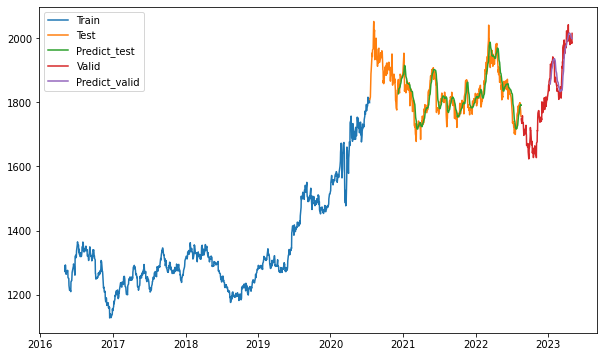

In [19]:
plt.figure(figsize=(10,6))
plt.plot(df['Date'][:train_size], data[:train_size].flatten(), label = "Train")
plt.plot(df['Date'][train_size:train_size+test_size], data[train_size:train_size+test_size].flatten(), label = "Test")
plt.plot(df['Date'][train_size+time_step:train_size+test_size], y_pred_test, label = "Predict_test")
plt.plot(df['Date'][train_size+test_size:], data[train_size+test_size:].flatten(), label = "Valid")
plt.plot(df['Date'][train_size+test_size+time_step:], y_pred_val, label = "Predict_valid")
plt.legend()
plt.show()

# Train(70%) - Test(20%) - Valid(10%)

In [20]:
train_size = int(0.7*len(data_scaled))
test_size = int(0.2*len(data_scaled))
valid_size = len(data_scaled) - train_size - test_size
time_step = 100
X_train, X_test, X_valid, y_train, y_test, y_valid = Train_test_split(data_scaled, n_steps=time_step, train_size=train_size, test_size=test_size)

In [21]:
model = LSTM_model(X_train, y_train, X_test, y_test)

Epoch 1/300
36/36 [==============================] - 8s 101ms/step - loss: 0.0171 - val_loss: 0.0014
Epoch 2/300
36/36 [==============================] - 3s 70ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 3/300
36/36 [==============================] - 3s 74ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 4/300
36/36 [==============================] - 3s 71ms/step - loss: 0.0010 - val_loss: 0.0016
Epoch 5/300
36/36 [==============================] - 3s 74ms/step - loss: 9.9067e-04 - val_loss: 0.0013
Epoch 6/300
36/36 [==============================] - 3s 73ms/step - loss: 9.2960e-04 - val_loss: 0.0013
Epoch 7/300
36/36 [==============================] - 3s 72ms/step - loss: 9.2414e-04 - val_loss: 0.0012
Epoch 8/300
36/36 [==============================] - 3s 74ms/step - loss: 9.9790e-04 - val_loss: 0.0015
Epoch 9/300
36/36 [==============================] - 3s 79ms/step - loss: 9.0394e-04 - val_loss: 0.0013
Epoch 10/300
36/36 [==============================] - 3s 77ms/step - loss: 8.56

In [22]:
y_pred_test, rmse, mape, mae = Eval_model(model, X_test, y_test)
y_pred_val, _, _, _ = Eval_model(model, X_valid, y_valid)
RMSE[1] = rmse
MAPE[1] = str(mape)+'%'
MAE[1] = mae
print(f"RMSE score of the model: {rmse}")
print(f"MAPE score of the model: {mape}%")
print(f"MAE score of the model: {mae}")

3/3 [==============================] - 0s 23ms/step
RMSE score of the model: 31.7
MAPE score of the model: 1.36%
MAE score of the model: 25.0


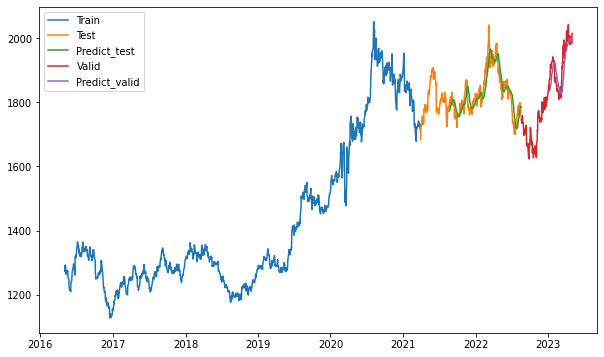

In [23]:
plt.figure(figsize=(10,6))
plt.plot(df['Date'][:train_size], data[:train_size].flatten(), label = "Train")
plt.plot(df['Date'][train_size:train_size+test_size], data[train_size:train_size+test_size].flatten(), label = "Test")
plt.plot(df['Date'][train_size+time_step:train_size+test_size], y_pred_test, label = "Predict_test")
plt.plot(df['Date'][train_size+test_size:], data[train_size+test_size:].flatten(), label = "Valid")
plt.plot(df['Date'][train_size+test_size+time_step:], y_pred_val, label = "Predict_valid")
plt.legend()
plt.show()

# Train(80%) - Test(10%) - Valid(10%)

In [24]:
train_size = int(0.8*len(data_scaled))
test_size = int(0.1*len(data_scaled))
valid_size = len(data_scaled) - train_size - test_size
time_step = 100
X_train, X_test, X_valid, y_train, y_test, y_valid = Train_test_split(data_scaled, n_steps=time_step, train_size=train_size, test_size=test_size)

In [25]:
model = LSTM_model(X_train, y_train, X_test, y_test)

Epoch 1/300
41/41 [==============================] - 8s 90ms/step - loss: 0.0178 - val_loss: 0.0041
Epoch 2/300
41/41 [==============================] - 3s 74ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 3/300
41/41 [==============================] - 3s 83ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 4/300
41/41 [==============================] - 4s 86ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 5/300
41/41 [==============================] - 3s 75ms/step - loss: 0.0011 - val_loss: 0.0033
Epoch 6/300
41/41 [==============================] - 3s 73ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 7/300
41/41 [==============================] - 3s 73ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 8/300
41/41 [==============================] - 3s 78ms/step - loss: 9.8367e-04 - val_loss: 0.0023
Epoch 9/300
41/41 [==============================] - 3s 77ms/step - loss: 9.6266e-04 - val_loss: 0.0013
Epoch 10/300
41/41 [==============================] - 3s 81ms/step - loss: 8.8192e-04 - val_

In [26]:
y_pred_test, rmse, mape, mae = Eval_model(model, X_test, y_test)
y_pred_val, _, _, _ = Eval_model(model, X_valid, y_valid)
RMSE[2] = rmse
MAPE[2] = str(mape)+'%'
MAE[2] = mae
print(f"RMSE score of the model: {rmse}")
print(f"MAPE score of the model: {mape}%")
print(f"MAE score of the model: {mae}")

3/3 [==============================] - 0s 58ms/step
RMSE score of the model: 15.7
MAPE score of the model: 0.66%
MAE score of the model: 11.8


In [27]:
y_pred_30days = []
time_data = df['Date'][-1:]
time_30days = pd.Series(pd.date_range(df['Date'][-1:].values[0], periods=30, freq='D'))
temp_input = data_scaled[-time_step:]

In [28]:
for i in tqdm(range(30)):
    pred_next_day = model.predict(temp_input[i:i+time_step].reshape(1,time_step,1), verbose=0)
    y_pred_30days.append(scaler.inverse_transform(pred_next_day)[0][0])
    temp_input = np.append(temp_input, pred_next_day)

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:03<00:00,  9.03it/s]


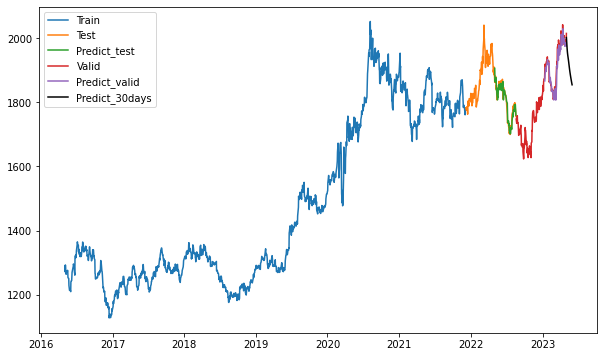

In [29]:
plt.figure(figsize=(10,6))
plt.plot(df['Date'][:train_size], data[:train_size].flatten(), label = "Train")
plt.plot(df['Date'][train_size:train_size+test_size], data[train_size:train_size+test_size].flatten(), label = "Test")
plt.plot(df['Date'][train_size+time_step:train_size+test_size], y_pred_test, label = "Predict_test")
plt.plot(df['Date'][train_size+test_size:], data[train_size+test_size:].flatten(), label = "Valid")
plt.plot(df['Date'][train_size+test_size+time_step:], y_pred_val, label = "Predict_valid")
plt.plot(time_30days, y_pred_30days, label = "Predict_30days", color='black')
plt.legend()
plt.show()

In [30]:
import pandas as pd
pd.DataFrame([RMSE, MAPE, MAE], columns=['6-3-1', '7-2-1', '8-1-1'], index=['RMSE', 'MAPE', 'MAE'])

,6-3-1,7-2-1,8-1-1
RMSE,30.5,31.7,15.7
MAPE,1.27%,1.36%,0.66%
MAE,23.0,25.0,11.8
